# 영주시 날씨에 따른 사과 가격 예측 - LSTM

##### 라이브러리 불러오기

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split


##### 데이터 불러오기 및 전처리

In [187]:
df = pd.read_excel('./back_data.xlsx')
df

,일시,평균가격(원),총거래물량(kg),환산,총거래금액(원),평균기온(°C),최저기온(°C),최고기온(°C),강수량,최대 순간 풍속(m/s),...,최소 상대습도(%),평균 상대습도(%),평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최저 해면기압(hPa),평균 해면기압(hPa),평균 지면온도(°C),최저 초상온도(°C),취약계층수
0,2020-01-02,23825.000000,1200.0,2515920.0,2859000,0.7,-4.8,4.0,3.328571,13.3,...,52,65.6,4.2,1002.4,1031.4,1027.3,1029.0,-0.1,-6.1,35339
1,2020-01-03,20758.489360,69636.0,139956432.0,159041400,2.0,-1.9,5.3,3.971429,12.8,...,33,52.9,3.7,999.3,1027.9,1023.7,1025.7,1.5,-3.7,35339
2,2020-01-04,29777.616742,81055.0,123458808.0,140294100,0.3,-6.3,5.7,4.614286,11.8,...,42,61.4,3.8,999.0,1028.8,1022.6,1025.5,0.3,-9.2,35339
3,2020-01-05,0.000000,0.0,0.0,0,-1.6,-8.4,6.6,5.257143,3.4,...,34,68.3,3.6,1004.6,1033.1,1028.7,1031.5,-0.8,-11.1,35339
4,2020-01-06,28609.448045,202560.0,404217792.0,459338400,0.9,-4.6,3.7,5.900000,3.8,...,54,81.3,5.4,1002.0,1032.5,1023.9,1028.5,0.5,-6.7,35339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,2024-03-09,90588.023414,6520.0,29052800.0,29052800,1.9,-2.9,7.4,0.700000,9.8,...,20,44.1,3.0,997.2,1026.5,1020.4,1023.6,4.3,-5.0,36547
1529,2024-03-10,0.000000,0.0,0.0,0,3.6,-5.6,10.7,0.700000,10.7,...,21,45.8,3.3,1001.5,1030.3,1025.8,1027.8,4.8,-8.2,36547
1530,2024-03-11,95224.193359,78590.0,411866200.0,411866200,4.1,-2.4,10.4,0.700000,3.7,...,29,58.1,4.4,994.9,1027.5,1016.7,1021.0,4.0,-4.4,36547
1531,2024-03-12,87635.755649,74070.0,375004900.0,375004900,3.5,-1.4,10.6,0.000000,7.1,...,48,77.1,6.0,989.6,1019.4,1013.3,1015.7,3.7,-4.2,36547


In [188]:
# 화폐가치 환산한 금액으로 예측할 것이기 때문에 총 거래금액(원) 컬럼 제거

df.drop('총거래금액(원)', axis=1, inplace=True)

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533 entries, 0 to 1532
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   일시             1533 non-null   datetime64[ns]
 1   평균가격(원)        1533 non-null   float64       
 2   총거래물량(kg)      1533 non-null   float64       
 3   환산             1533 non-null   float64       
 4   평균기온(°C)       1531 non-null   float64       
 5   최저기온(°C)       1533 non-null   float64       
 6   최고기온(°C)       1533 non-null   float64       
 7   강수량            1533 non-null   float64       
 8   최대 순간 풍속(m/s)  1533 non-null   float64       
 9   최대 순간 풍속 풍향    1533 non-null   int64         
 10  최대 풍속(m/s)     1532 non-null   float64       
 11  최대 풍속 풍향       1533 non-null   int64         
 12  평균 풍속(m/s)     1533 non-null   float64       
 13  풍정합(100m)      1533 non-null   int64         
 14  최다풍향           1530 non-null   float64       
 15  평균 이슬점온도(°C)   1531 n

In [190]:
df.isna().sum()

일시               0
평균가격(원)          0
총거래물량(kg)        0
환산               0
평균기온(°C)         2
최저기온(°C)         0
최고기온(°C)         0
강수량              0
최대 순간 풍속(m/s)    0
최대 순간 풍속 풍향      0
최대 풍속(m/s)       1
최대 풍속 풍향         0
평균 풍속(m/s)       0
풍정합(100m)        0
최다풍향             3
평균 이슬점온도(°C)     2
최소 상대습도(%)       0
평균 상대습도(%)       2
평균 증기압(hPa)      2
평균 현지기압(hPa)     2
최고 해면기압(hPa)     0
최저 해면기압(hPa)     1
평균 해면기압(hPa)     2
평균 지면온도(°C)      0
최저 초상온도(°C)      0
취약계층수            0
dtype: int64

In [191]:
# Null값 처리
df['평균기온(°C)'] = df['평균기온(°C)'].fillna(round(np.mean(df['평균기온(°C)']),2))
# df['강수량'] = df['강수량'].fillna(0)
df['최대 풍속(m/s)'] = df['최대 풍속(m/s)'].fillna(round(np.mean(df['최대 풍속(m/s)']), 2))
df['최다풍향'] = df['최다풍향'].fillna(round(np.mean(df['최다풍향']), 2))
df['평균 이슬점온도(°C)'] = df['평균 이슬점온도(°C)'].fillna(round(np.mean(df['평균 이슬점온도(°C)']), 2))
df['평균 상대습도(%)'] = df['평균 상대습도(%)'].fillna(round(np.mean(df['평균 상대습도(%)']), 2))
df['평균 증기압(hPa)'] = df['평균 증기압(hPa)'].fillna(round(np.mean(df['평균 증기압(hPa)']), 2))
df['평균 현지기압(hPa)'] = df['평균 현지기압(hPa)'].fillna(round(np.mean(df['평균 현지기압(hPa)']), 2))
df['최저 해면기압(hPa)'] = df['최저 해면기압(hPa)'].fillna(round(np.mean(df['최저 해면기압(hPa)']), 2))
df['평균 해면기압(hPa)'] = df['평균 해면기압(hPa)'].fillna(round(np.mean(df['평균 해면기압(hPa)']), 2))

# 환산 (총 거래금액) 0원인 행  제거
df = df[df['환산'] != 0]

# 날짜 열을 인덱스로 설정
df.set_index('일시', inplace=True)

df.head()

,평균가격(원),총거래물량(kg),환산,평균기온(°C),최저기온(°C),최고기온(°C),강수량,최대 순간 풍속(m/s),최대 순간 풍속 풍향,최대 풍속(m/s),...,최소 상대습도(%),평균 상대습도(%),평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최저 해면기압(hPa),평균 해면기압(hPa),평균 지면온도(°C),최저 초상온도(°C),취약계층수
일시,,,,,,,,,,,,,,,,,,,,,
2020-01-02,23825.000000,1200.0,2515920.0,0.7,-4.8,4.0,3.328571,13.3,290,8.0,...,52,65.6,4.2,1002.4,1031.4,1027.3,1029.0,-0.1,-6.1,35339
2020-01-03,20758.489360,69636.0,139956432.0,2.0,-1.9,5.3,3.971429,12.8,320,7.2,...,33,52.9,3.7,999.3,1027.9,1023.7,1025.7,1.5,-3.7,35339
2020-01-04,29777.616742,81055.0,123458808.0,0.3,-6.3,5.7,4.614286,11.8,270,6.8,...,42,61.4,3.8,999.0,1028.8,1022.6,1025.5,0.3,-9.2,35339
2020-01-06,28609.448045,202560.0,404217792.0,0.9,-4.6,3.7,5.900000,3.8,340,2.7,...,54,81.3,5.4,1002.0,1032.5,1023.9,1028.5,0.5,-6.7,35339
2020-01-07,28631.750371,144105.0,272658848.0,6.6,3.0,9.4,58.400000,5.7,250,3.4,...,100,100.0,9.7,987.1,1023.9,999.4,1012.7,5.7,3.0,35339


In [192]:
df.isna().sum()

평균가격(원)          0
총거래물량(kg)        0
환산               0
평균기온(°C)         0
최저기온(°C)         0
최고기온(°C)         0
강수량              0
최대 순간 풍속(m/s)    0
최대 순간 풍속 풍향      0
최대 풍속(m/s)       0
최대 풍속 풍향         0
평균 풍속(m/s)       0
풍정합(100m)        0
최다풍향             0
평균 이슬점온도(°C)     0
최소 상대습도(%)       0
평균 상대습도(%)       0
평균 증기압(hPa)      0
평균 현지기압(hPa)     0
최고 해면기압(hPa)     0
최저 해면기압(hPa)     0
평균 해면기압(hPa)     0
평균 지면온도(°C)      0
최저 초상온도(°C)      0
취약계층수            0
dtype: int64

In [193]:
df['환산'].max(), df['환산'].min()

(1327419730.5, 1419120.0)

##### 2024-03-13 예측하기 위해 마지막 컬럼 제거

In [194]:
df = df.iloc[:-1]
df

,평균가격(원),총거래물량(kg),환산,평균기온(°C),최저기온(°C),최고기온(°C),강수량,최대 순간 풍속(m/s),최대 순간 풍속 풍향,최대 풍속(m/s),...,최소 상대습도(%),평균 상대습도(%),평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최저 해면기압(hPa),평균 해면기압(hPa),평균 지면온도(°C),최저 초상온도(°C),취약계층수
일시,,,,,,,,,,,,,,,,,,,,,
2020-01-02,23825.000000,1200.0,2515920.0,0.7,-4.8,4.0,3.328571,13.3,290,8.0,...,52,65.6,4.2,1002.4,1031.4,1027.3,1029.0,-0.1,-6.1,35339
2020-01-03,20758.489360,69636.0,139956432.0,2.0,-1.9,5.3,3.971429,12.8,320,7.2,...,33,52.9,3.7,999.3,1027.9,1023.7,1025.7,1.5,-3.7,35339
2020-01-04,29777.616742,81055.0,123458808.0,0.3,-6.3,5.7,4.614286,11.8,270,6.8,...,42,61.4,3.8,999.0,1028.8,1022.6,1025.5,0.3,-9.2,35339
2020-01-06,28609.448045,202560.0,404217792.0,0.9,-4.6,3.7,5.900000,3.8,340,2.7,...,54,81.3,5.4,1002.0,1032.5,1023.9,1028.5,0.5,-6.7,35339
2020-01-07,28631.750371,144105.0,272658848.0,6.6,3.0,9.4,58.400000,5.7,250,3.4,...,100,100.0,9.7,987.1,1023.9,999.4,1012.7,5.7,3.0,35339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-07,89017.336423,45830.0,232185400.0,2.7,1.0,5.2,0.700000,12.5,320,8.4,...,40,73.8,5.5,991.4,1020.8,1014.4,1017.5,4.6,0.7,36547
2024-03-08,88017.406893,50820.0,239655700.0,2.1,-0.6,7.1,0.700000,15.7,320,9.7,...,25,50.3,3.5,990.6,1020.4,1013.8,1016.8,4.2,-1.4,36547
2024-03-09,90588.023414,6520.0,29052800.0,1.9,-2.9,7.4,0.700000,9.8,320,6.4,...,20,44.1,3.0,997.2,1026.5,1020.4,1023.6,4.3,-5.0,36547


##### 상관관계 분석

<Axes: >

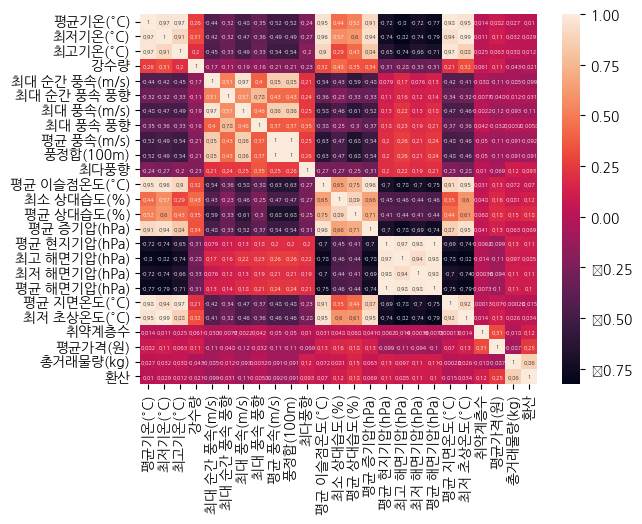

In [195]:
ccol = ['평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '강수량', '최대 순간 풍속(m/s)',
        '최대 순간 풍속 풍향', '최대 풍속(m/s)', '최대 풍속 풍향', '평균 풍속(m/s)', '풍정합(100m)', 
        '최다풍향', '평균 이슬점온도(°C)', '최소 상대습도(%)', '평균 상대습도(%)', '평균 증기압(hPa)',
        '평균 현지기압(hPa)', '최고 해면기압(hPa)', '최저 해면기압(hPa)', '평균 해면기압(hPa)', '평균 지면온도(°C)', 
        '최저 초상온도(°C)', '취약계층수', '평균가격(원)', '총거래물량(kg)', '환산']

corrs = df[ccol].corr()
sns.heatmap(corrs, annot=True, annot_kws={'size':4})

##### 스케일링

In [196]:
#필요한 컬럼만(속성&타겟) 선택
features = ['평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '강수량', '최대 순간 풍속(m/s)',
         '최대 풍속(m/s)', '최소 상대습도(%)', '평균 상대습도(%)', '평균 지면온도(°C)', 
        '최저 초상온도(°C)', '취약계층수', '평균가격(원)', '총거래물량(kg)','환산']

# 데이터 정규화
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

##### LSTM 입력 데이터 생성

In [197]:
def create_dataset(df, time_steps):
    X, y = [], []
    for i in range(len(df) - time_steps):
        X.append(df.iloc[i:(i + time_steps)][features[:-1]].values) # 마지막 열을 제외한 모든 열을 X에 추가
        y.append(df.iloc[i + time_steps][features[-1]])
    return np.array(X), np.array(y)

time_steps = 7 # 시계열 길이 설정 ( 조정 가능)
X, y = create_dataset(df, time_steps)

In [198]:
X.shape

(1267, 7, 13)

##### 데이터 셋 분할 (학습, 검증, 테스트)

In [199]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

##### LSTM 모델 생성, 학습 및 예측 수행

In [200]:
# LSTM 모델 생성
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'),
    Dropout(rate=0.5),  # Dropout 추가
    LSTM(units=50, return_sequences=True, activation='tanh'),  # 두 번째 LSTM 층
    Dropout(rate=0.5),  # Dropout 추가
    LSTM(units=50,activation='tanh'),  # 세 번째 LSTM 층 (마지막 층이므로 return_sequences=False로 설정)
    Dropout(rate=0.5),  # Dropout 추가
    Dense(64, activation='relu'),  # 은닉층
    # BatchNormalization(),  # 배치 정규화
    Dense(1)  # 출력층
])

# 모델 컴파일 (손실 함수로 MSE 사용)
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

# 모델 평가
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

Epoch 1/10
28/28 [==============================] - 6s 49ms/step - loss: 0.1003 - mse: 0.0248 - val_loss: 0.0568 - val_mse: 0.0090
Epoch 2/10
28/28 [==============================] - 0s 9ms/step - loss: 0.0924 - mse: 0.0217 - val_loss: 0.0559 - val_mse: 0.0086
Epoch 3/10
28/28 [==============================] - 0s 9ms/step - loss: 0.0825 - mse: 0.0170 - val_loss: 0.0569 - val_mse: 0.0079
Epoch 4/10
28/28 [==============================] - 0s 9ms/step - loss: 0.0754 - mse: 0.0136 - val_loss: 0.0610 - val_mse: 0.0091
Epoch 5/10
28/28 [==============================] - 0s 9ms/step - loss: 0.0742 - mse: 0.0136 - val_loss: 0.0597 - val_mse: 0.0084
Epoch 6/10
28/28 [==============================] - 0s 8ms/step - loss: 0.0717 - mse: 0.0138 - val_loss: 0.0590 - val_mse: 0.0088
Epoch 7/10
28/28 [==============================] - 0s 8ms/step - loss: 0.0713 - mse: 0.0133 - val_loss: 0.0579 - val_mse: 0.0085
Test Loss: [0.1951305866241455, 0.07119543850421906]


In [201]:
pd.DataFrame(history.history)

,loss,mse,val_loss,val_mse
0,0.100331,0.024776,0.056777,0.008961
1,0.092366,0.021664,0.055923,0.008622
2,0.082527,0.017023,0.056913,0.007912
3,0.075420,0.013599,0.061019,0.009074
4,0.074192,0.013561,0.059738,0.008376
5,0.071733,0.013825,0.058990,0.008806
6,0.071251,0.013294,0.057872,0.008490


##### 2024-03-13 사과 가격 예측

In [202]:
last_sequence = df.iloc[-time_steps:][features[:-1]].values
last_sequence = np.expand_dims(last_sequence, axis=0)
predicted_value = model.predict(last_sequence)
## 원래의 값 = (정규화된 값 * (max - min)) + min
predicted_value = (predicted_value * (1327419730.5 - 1419120.0)) + 1419120.0
print(f"2024년 3월 13일 사과 총 거래금액 예측 : {predicted_value}")

1/1 [==============================] - 3s 3s/step
2024년 3월 13일 사과 총 거래금액 예측 : [[1.650316e+08]]


In [203]:
# 일반적인 숫자 형식으로 변환
number_in_standard_form = np.format_float_positional(predicted_value)

print(number_in_standard_form)

165031600.


##### 3월 13일 실제 거래금액은 3억원대로 오차가 큰 것을 확인
##### 더 분석 예정